# Demo Video smooth version

In [1]:
from LK_optical_flow.utils import showarray
from two_stream import Two_stream

import os, sys, cv2, time
old_stdout = sys.stdout

import configparser
import numpy as np

from contextlib import contextmanager

@contextmanager
def silence_stdout():
    old_target = sys.stdout
    try:
        with open(os.devnull, "w") as new_target:
            sys.stdout = new_target
            yield new_target
    finally:
        sys.stdout = old_target
        

In [2]:
## configs
config = configparser.ConfigParser()
config.read('./files/config.config')

size = (ch,h,w) = (config['OpticalFlow']['channel'],
                   int(config['DataConfig']['image_height']),int(config['DataConfig']['image_width'])) #(20,256,256)

fps_list = []
start,end,sec = 0,0,1e-4

In [3]:
import ctypes
import numpy as np
import multiprocessing as mp

from multiprocessing import Process

def action_recogn_job(curr_frame, prev_frame, output):
    global two_stream
    
    with silence_stdout():
        output[:] = two_stream(curr_frame, prev_frame)

output = mp.Array(ctypes.c_float, 101)
ps_two_stream = None #Process(target=self.spatial_job, args=(input_frame, 0))


In [4]:
two_stream = Two_stream('./files/config.config')

	[Info] buff depth 65536
	[Info] buff depth 131072
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 65536
[[[[ 58 128 111]
   [146  64 112]
   [ 56  92 162]]

  [[131 184 111]
   [ 96 156 109]
   [169 176 213]]

  [[142 100 192]
   [ 72  79 175]
   [ 87 181 134]]]


 [[[ 89 111 152]
   [203 161  85]
   [ 60  85 136]]

  [[170 205 143]
   [209 192 103]
   [ 95 172 102]]

  [[ 77 104 140]
   [150  91 160]
   [128 155  52]]]


 [[[ 92 107  28]
   [233 171 140]
   [187 214 185]]

  [[120  45  17]
   [215  91  62]
   [ 90 105 123]]

  [[149  90  76]
   [249 165 101]
   [161 138  8

In [5]:
delay_list = []
def demo(video_path='LK_optical_flow/files/Big.Buck.Bunny.mp4'):
    global sec, output, ps_two_stream, h, w, max_fps, fps_list
    
    # put demo video
    cap = cv2.VideoCapture(video_path)
    #cap = cv2.VideoCapture(0)
    max_fps = 0
    prev_frame = np.zeros((h,w,3)).astype(np.uint8)
    prev_frame_gray = np.zeros((h,w)).astype(np.uint8)
    while(True):
        start = time.time()

        ret,frame = cap.read()
        if ret:            
            curr_frame = cv2.resize(frame, (h, w))
            curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
            curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
            
            start = time.time()
            
            # luccas kannade , fbank
            vx,vy = two_stream.lucas_kanade_acc.compute(prev_frame_gray, curr_frame_gray)
            
            end = time.time()
            delay_list.append(end-start)
            
            two_stream.feature_bank.push(vx,vy)
            
#             action_recogn_job(curr_frame, prev_frame, output)
            if ps_two_stream==None or not ps_two_stream.is_alive():
                ps_two_stream = Process(target=action_recogn_job, args=(curr_frame, prev_frame, output))
                ps_two_stream.start()

            ## class 
            k = 3
            pred_action = np.argpartition(np.array(output), -k)[-k:]+1 #top-k

            prev_frame = curr_frame
            prev_frame_gray = curr_frame_gray

            ####################
            ##### just show ####
            vx = np.expand_dims(vx, axis=2)
            vy = np.expand_dims(vy, axis=2)
            #vv = np.sqrt((vx**2+vy**2))
            vv = np.zeros((h,w,1))
            v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
            showarray(np.concatenate((curr_frame,v),axis=1), 1/sec, topk=pred_action)
            ####################
            #showarray(curr_frame, 1/sec, show_meta=False)
        else:
            break

        end = time.time()
        sec = end-start
        fps_val = 1.0/sec
        fps_list.append(fps_val)
        if(max_fps < fps_val):
            max_fps = fps_val
        


        #print(sec)

    print(f"avg fps:{sum(fps_list)/len(fps_list)} the highest fps is: {max_fps}")


In [6]:
import cv2
import threading, time


import multiprocessing
import cv2

queue_from_cam = multiprocessing.Queue()

def cam_loop(queue_from_cam):
    #print 'initializing cam'
    cap = cv2.VideoCapture(0)
    while True:
        
        #print 'querying frame'
        ret, img = cap.read()
        #print 'queueing image'
        queue_from_cam.put(img)
        #print 'cam_loop done'
    
    
cam_process = multiprocessing.Process(target=cam_loop ,args=(queue_from_cam,))
cam_process.daemon = True
delay_list = []
def testCam():
    global sec, output, ps_two_stream, h, w, max_fps, fps_list, cam_process, queue_from_cam
    
    # put demo video
    #cap = cv2.VideoCapture(video_path)
    #cap = cv2.VideoCapture(0)
    #cap = VideoCapture(0)
    cam_process.start()    
    time.sleep(0.5)
    
    max_fps = 0
    prev_frame = np.zeros((h,w,3)).astype(np.uint8)
    prev_frame_gray = np.zeros((h,w)).astype(np.uint8)
    while(True):
        start = time.time()
        
        if cam_process==None or (not cam_process.is_alive()):
            cam_process.start()
        #ret,frame = cap.read()
        #if ret: 
        if not queue_from_cam.empty():
            frame = queue_from_cam.get()
            
            
            #try:
            curr_frame = cv2.resize(frame, (h, w))
            curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
            curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)
            #except:
            #    pass
            
            
            start = time.time()
            
            # luccas kannade , fbank
            vx,vy = two_stream.lucas_kanade_acc.compute(prev_frame_gray, curr_frame_gray)
            
            end = time.time()
            delay_list.append(end-start)
            
            two_stream.feature_bank.push(vx,vy)
            
#             action_recogn_job(curr_frame, prev_frame, output)
            if ps_two_stream==None or (not ps_two_stream.is_alive()):
                ps_two_stream = Process(target=action_recogn_job, args=(curr_frame, prev_frame, output))
                ps_two_stream.start()

            ## class 
            k = 5
            pred_action = np.argpartition(np.array(output), -k)[-k:]+1 #top-k

            prev_frame = curr_frame
            prev_frame_gray = curr_frame_gray

            ###################
            ##### just show ####
            vx = np.expand_dims(vx, axis=2)
            vy = np.expand_dims(vy, axis=2)
            #vv = np.sqrt((vx**2+vy**2))
            vv = np.zeros((h,w,1))
            v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
            showarray(curr_frame, 1/sec, topk=pred_action)
            ####################
            #showarray(curr_frame, 1/sec, show_meta=False)
        else:
            time.sleep(0.05)
            #continue
            
            #cam_process.start()
            #pass
        
            #break

        end = time.time()
        sec = end-start
        fps_val = 1.0/sec
        fps_list.append(fps_val)
        if(max_fps < fps_val):
            max_fps = fps_val
        
    cam_process.join() 

        #print(sec)

    print(f"avg fps:{sum(fps_list)/len(fps_list)} the highest fps is: {max_fps}")


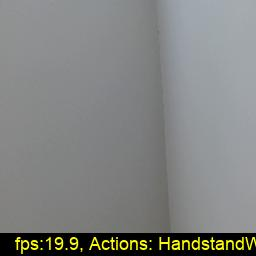

In [ ]:
import random
import glob

# testCam()


video_candidate0 = [
    'LK_optical_flow/files/v_BaseballPitch_g17_c05.avi',
                    'LK_optical_flow/files/v_BaseballPitch_g17_c01.avi',
                   'LK_optical_flow/files/v_BaseballPitch_g17_c02.avi',
                   'LK_optical_flow/files/v_BaseballPitch_g17_c03.avi'
                   ]
for vd in video_candidate0:
    demo(vd)
    
video_candidate1 = glob.glob('LK_optical_flow/files/*.avi')
random.shuffle(video_candidate1)

#for vd in video_candidate1:
#    demo(vd)
    

In [ ]:
sum(delay_list)/len(delay_list)
#print("The delay list is:", delay_list)

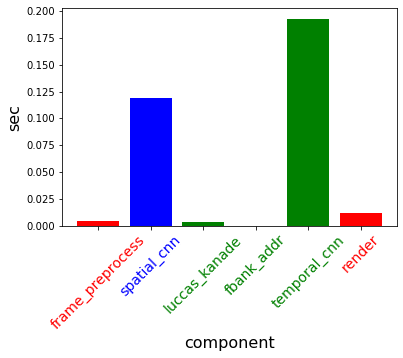

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

y = np.array([4.633, 119, 3.58, 0.000151, 193, 11.57])/1000
x_label = ['frame_preprocess','spatial_cnn','luccas_kanade','fbank_addr','temporal_cnn','render']
x_color = ['red','blue','green','green','green','red']

plt.ylabel('sec',fontsize=16)
plt.xlabel('component',fontsize=16)
plt.xticks(np.arange(len(y)), x_label, rotation=45, fontsize=14)
plt.xticks(fontsize=14)

for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), x_color):
    ticklabel.set_color(tickcolor)

plt.bar(range(len(y)),y, color=x_color)

plt.show()
